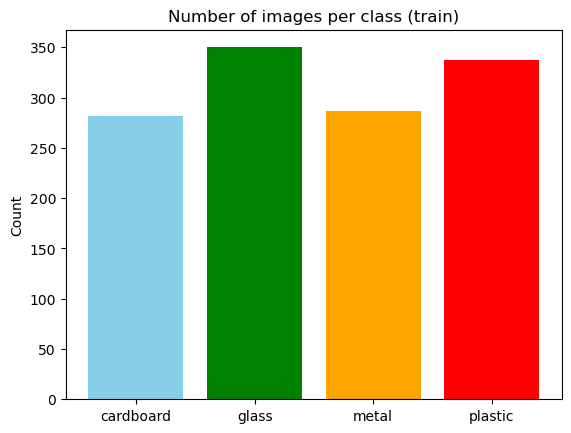

Image counts per class: {'cardboard': 282, 'glass': 350, 'metal': 287, 'plastic': 337}


In [3]:
import os
import matplotlib.pyplot as plt

dataset_dir = "dataset/train"
classes = ["cardboard", "glass", "metal", "plastic"]

counts = [len(os.listdir(os.path.join(dataset_dir, c))) for c in classes]

plt.bar(classes, counts, color=['skyblue','green','orange','red'])
plt.title("Number of images per class (train)")
plt.ylabel("Count")
plt.show()

print("Image counts per class:", dict(zip(classes, counts)))


## Augmentation Comparison

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'dataset/train'
val_dir = 'dataset/validation'

train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_aug = train_datagen_aug.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=16, class_mode='categorical'
)

train_datagen_no_aug = ImageDataGenerator(rescale=1./255)
train_no_aug = train_datagen_no_aug.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=16, class_mode='categorical'
)


Found 1256 images belonging to 4 classes.
Found 1256 images belonging to 4 classes.


Found 272 images belonging to 4 classes.
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 799ms/step
              precision    recall  f1-score   support

   cardboard       1.00      0.97      0.98        61
       glass       0.84      0.84      0.84        76
       metal       0.85      0.89      0.87        62
     plastic       0.85      0.84      0.84        73

    accuracy                           0.88       272
   macro avg       0.88      0.88      0.88       272
weighted avg       0.88      0.88      0.88       272



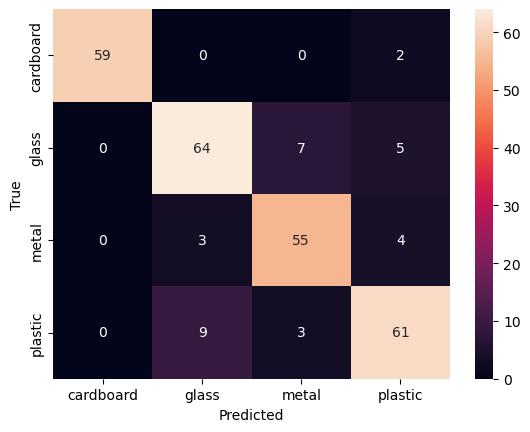

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

model = load_model("waste_classifier_model.h5")
test_dir = 'dataset/test'

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False)

y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
class_labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Error Analysis

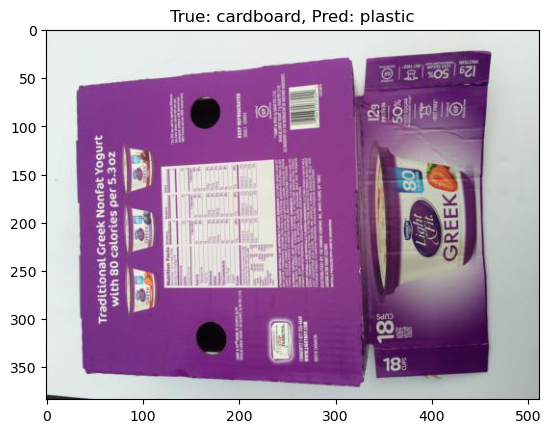

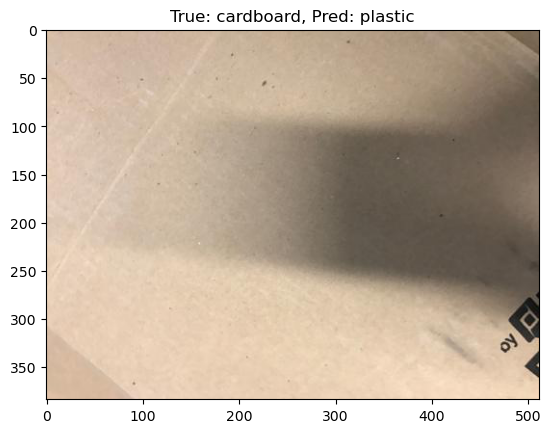

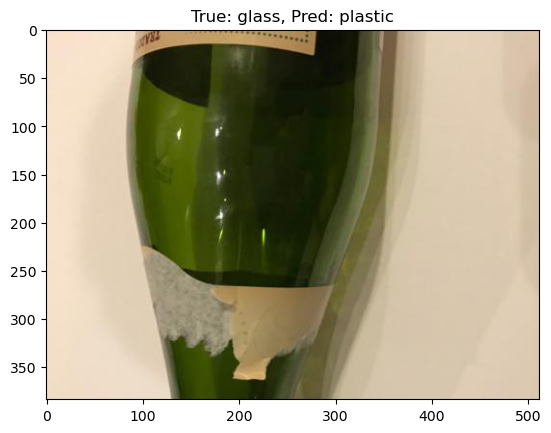

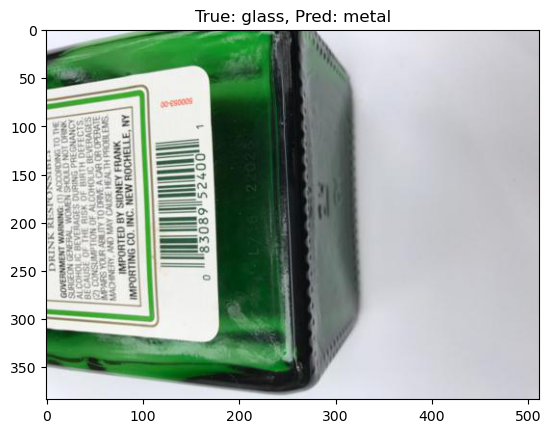

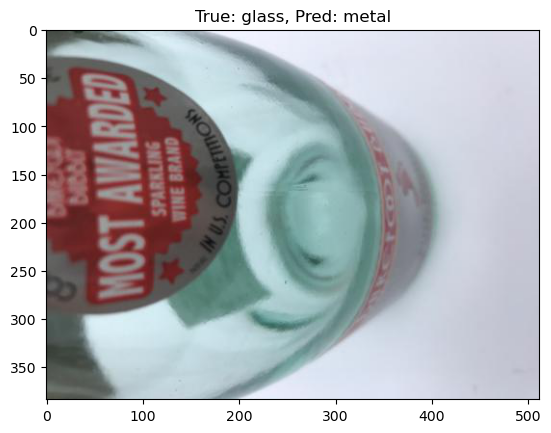

In [11]:
misclassified_idx = np.where(y_true != y_pred_classes)[0]

for idx in misclassified_idx[:5]:
    img_path = test_gen.filepaths[idx]
    plt.imshow(plt.imread(img_path))
    plt.title(f"True: {class_labels[y_true[idx]]}, Pred: {class_labels[y_pred_classes[idx]]}")
    plt.show()


## Explainability

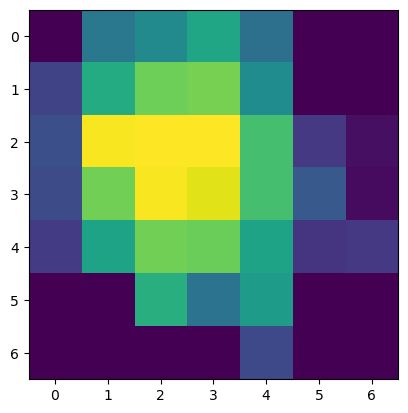

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def grad_cam(model, img_array, class_index):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer("Conv_1").output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Example usage:
from tensorflow.keras.preprocessing import image

img_path = 'dataset/test/plastic/plastic5.jpg'
img = image.load_img(img_path, target_size=(224,224))
img_array = np.expand_dims(image.img_to_array(img)/255.0, axis=0)

heatmap = grad_cam(model, img_array, class_index=class_labels.index("plastic"))
plt.imshow(heatmap, cmap='viridis')
plt.show()
